this is an example of using target encoding with keras neural network to solve this problem. if you are interesting in *my solution with logit and cat boost*, see [this notebook](https://www.kaggle.com/fkdplc/ensembling-logisticregression-and-catboost).

In [1]:
import numpy as np
import pandas as pd
import os
import math
from tqdm.notebook import tqdm
from sklearn.exceptions import ConvergenceWarning
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

PATH = '/kaggle/input/cat-in-the-dat-ii/'
train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')

# separate target, remove id and target
test_ids = test['id']
target = train['target']
train.drop(columns=['id', 'target'], inplace=True)
test.drop(columns=['id'], inplace=True)

train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,...,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0
1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,...,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0
2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,...,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0
3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,...,bdaa56dd1,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0
4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,...,NaN,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0


In [2]:
import category_encoders as ce

te = ce.TargetEncoder(cols=train.columns.values, smoothing=0.3).fit(train, target)

train = te.transform(train)
train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month
0,0.194674,0.190560,0.17113,0.186772,0.180234,0.183067,0.225464,0.168014,0.219534,0.207375,...,0.128509,0.164251,0.239775,0.172972,0.205176,0.113524,0.222938,0.143608,0.199832,0.146451
1,0.113365,0.172274,0.17113,0.186772,0.195305,0.183067,0.130201,0.201104,0.185862,0.179573,...,0.197291,0.152830,0.239775,0.232669,0.175404,0.135513,0.233747,0.236897,0.212460,0.209293
2,0.194674,0.172274,0.17113,0.186772,0.180234,0.183067,0.182805,0.168014,0.159849,0.207375,...,0.172607,0.187849,0.239775,0.187406,0.132253,0.289383,0.201003,0.208738,0.163537,0.211688
3,0.188387,0.190560,0.17113,0.186772,0.180234,0.183067,0.179694,0.168014,0.178947,0.179573,...,0.224036,0.268456,0.142060,0.156024,0.290762,0.091502,0.138982,0.184215,0.164080,0.146451
4,0.194674,0.188413,0.17113,0.187868,0.180234,0.183067,0.157360,0.168014,0.202836,0.185528,...,0.191777,0.250000,0.239775,0.232669,0.152205,0.182082,0.138982,0.160131,0.163537,0.225841


In [3]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train, target, test_size=0.2, random_state=289)

x_train.shape, x_test.shape

((480000, 23), (120000, 23))

this is the main code of snapshot ensembling method. you can see [my tutorial about snapshot ensembles and cosine annealing](https://www.kaggle.com/fkdplc/snapshot-ensemble-tutorial-with-keras)

In [4]:
from keras.callbacks import Callback
from keras import backend
from keras.models import load_model

# this callback applies cosine annealing, saves snapshots and allows to load them
class SnapshotEnsemble(Callback):
    
    __snapshot_name_fmt = "snapshot_%d.hdf5"
    
    def __init__(self, n_models, n_epochs_per_model, lr_max, verbose=1):
        """
        n_models -- quantity of models (snapshots)
        n_epochs_per_model -- quantity of epoch for every model (snapshot)
        lr_max -- maximum learning rate (snapshot starter)
        """
        self.n_epochs_per_model = n_epochs_per_model
        self.n_models = n_models
        self.n_epochs_total = self.n_models * self.n_epochs_per_model
        self.lr_max = lr_max
        self.verbose = verbose
        self.lrs = []
 
    # calculate learning rate for epoch
    def cosine_annealing(self, epoch):
        cos_inner = (math.pi * (epoch % self.n_epochs_per_model)) / self.n_epochs_per_model
        return self.lr_max / 2 * (math.cos(cos_inner) + 1)

    # when epoch begins update learning rate
    def on_epoch_begin(self, epoch, logs={}):
        # update learning rate
        lr = self.cosine_annealing(epoch)
        backend.set_value(self.model.optimizer.lr, lr)
        # log value
        self.lrs.append(lr)

    # when epoch ends check if there is a need to save a snapshot
    def on_epoch_end(self, epoch, logs={}):
        if (epoch + 1) % self.n_epochs_per_model == 0:
            # save model to file
            filename = self.__snapshot_name_fmt % ((epoch + 1) // self.n_epochs_per_model)
            self.model.save(filename)
            if self.verbose:
                print('Epoch %d: snapshot saved to %s' % (epoch, filename))
                
    # load all snapshots after training
    def load_ensemble(self):
        models = []
        for i in range(self.n_models):
            models.append(load_model(self.__snapshot_name_fmt % (i + 1)))
        return models

Using TensorFlow backend.


In [5]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LeakyReLU

model = Sequential()
model.add(Dense(32, input_shape=(train.shape[1], )))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(16))
model.add(LeakyReLU())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                768       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [6]:
se_callback = SnapshotEnsemble(n_models=7, n_epochs_per_model=15, lr_max=.01)

history = model.fit(
    x_train,
    y_train,
    epochs=se_callback.n_epochs_total,
    verbose=1,
    batch_size=32,
    callbacks=[se_callback],
    validation_data=(x_test, y_test)
)

Train on 480000 samples, validate on 120000 samples
Epoch 1/105
480000/480000 [==============================] - 25s 53us/step - loss: 0.4285 - acc: 0.8159 - val_loss: 0.3935 - val_acc: 0.8287
Epoch 2/105
480000/480000 [==============================] - 25s 51us/step - loss: 0.4139 - acc: 0.8186 - val_loss: 0.4005 - val_acc: 0.8273
Epoch 3/105
480000/480000 [==============================] - 24s 51us/step - loss: 0.4115 - acc: 0.8194 - val_loss: 0.3910 - val_acc: 0.8275
Epoch 4/105
480000/480000 [==============================] - 25s 52us/step - loss: 0.4094 - acc: 0.8199 - val_loss: 0.3950 - val_acc: 0.8242
Epoch 5/105
480000/480000 [==============================] - 24s 51us/step - loss: 0.4070 - acc: 0.8208 - val_loss: 0.3966 - val_acc: 0.8293
Epoch 6/105
480000/480000 [==============================] - 25s 51us/step - loss: 0.4059 - acc: 0.8213 - val_loss: 0.3896 - val_acc: 0.8296
Epoch 7/105
480000/480000 [==============================] - 24s 51us/step - loss: 0.4045 - acc: 0.821

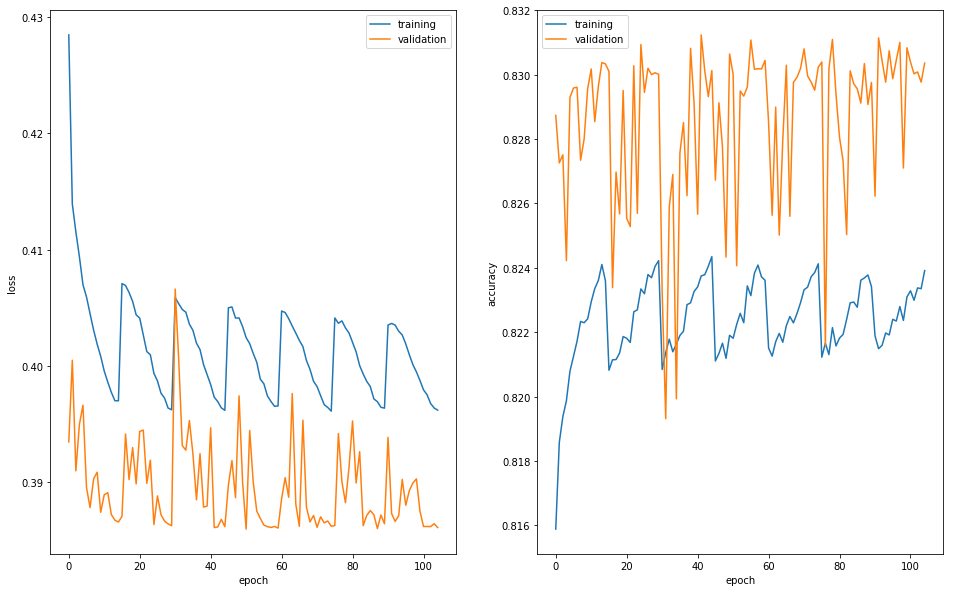

In [7]:
from matplotlib import pyplot as plt

h = history.history
plt.figure(1, figsize=(16, 10))

plt.subplot(121)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(h['loss'], label='training')
plt.plot(h['val_loss'], label='validation')
plt.legend()

plt.subplot(122)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(h['acc'], label='training')
plt.plot(h['val_acc'], label='validation')
plt.legend()

plt.show()

In [8]:
from sklearn.metrics import roc_auc_score

# makes prediction according to given models and given weights
def predict(models, data, weights=None):
    if weights is None:
        # default weights provide voting equality
        weights = [1 / (len(models))] * len(models)
    pred = np.zeros((data.shape[0], ))
    for i, model in enumerate(models):
        pred += model.predict(data).flatten() * weights[i]
    return pred

# returns roc auc for preds and weights
def evaluate(preds, weights=None):
    if weights is None:
        weights = [1 / len(preds)] * len(preds)
    y_true = np.zeros((y_test.shape[0], ))
    for i, pred in enumerate(preds):
        y_true += pred.flatten() * weights[i]
    return roc_auc_score(y_test, y_true)

# load list of snapshots
models = se_callback.load_ensemble()
preds = []
# evaluate every model as single
for i, model in enumerate(models):
    pred = predict([model], x_test)
    preds.append(pred)
    score = evaluate([pred])
    print(f'model {i + 1}: roc = {score:.4f}')

# evaluate ensemble (with voting equality)
ensemble_score = evaluate(preds)
print(f'ensemble: roc = {ensemble_score:.4f}')

model 1: roc = 0.7973
model 2: roc = 0.7979
model 3: roc = 0.7982
model 4: roc = 0.7982
model 5: roc = 0.7983
model 6: roc = 0.7983
model 7: roc = 0.7984
ensemble: roc = 0.7982


In [9]:
best_score = ensemble_score
best_weights = None
no_improvements = 0
while no_improvements < 500: #patience
    
    # generate normalized weights
    new_weights = np.random.uniform(size=(len(models), ))
    new_weights /= new_weights.sum()
    
    # get the score (no extra predictions)
    new_score = evaluate(preds, new_weights)
    
    # check (and save)
    if new_score > best_score:
        no_improvements = 0
        best_score = new_score
        best_weights = new_weights
        print(f'improvement: {best_score:.4f}')
    else:
        no_improvements += 1


print(f'best weights are {best_weights}')

improvement: 0.7983
improvement: 0.7983
improvement: 0.7983
improvement: 0.7983
improvement: 0.7983
best weights are [0.01412785 0.00976314 0.11186337 0.24619311 0.03077839 0.30790582
 0.27936831]


In [10]:
# transform test and predict
test = te.transform(test)
pred = predict(models, test, best_weights)

res = pd.DataFrame()
res['id'] = test_ids
res['target'] = pred
res.to_csv('submission.csv', index=False)
res.head(15)

,id,target
0,600000,0.092935
1,600001,0.272344
2,600002,0.140209
3,600003,0.139004
4,600004,0.133086
5,600005,0.080759
6,600006,0.529234
7,600007,0.119069
8,600008,0.211117
9,600009,0.317574


<h3>thank you for reading till the end! i hope you liked it!</h3>